In [21]:
list.of.packages = c('tidyverse', 'caret', 'gridExtra', 'glmnet')
new.packages = 
list.of.packages[!(list.of.packages 
                   %in% installed.packages()[,"Package"])]
if(length(new.packages)) install.packages(new.packages, 
                     repos='http://cran.us.r-project.org')
suppressWarnings(library(tidyverse, quietly = TRUE, warn.conflicts = FALSE))
suppressWarnings(library(caret, quietly = TRUE, warn.conflicts = FALSE))
suppressWarnings(require(gridExtra, quietly = TRUE, warn.conflicts = FALSE))
suppressWarnings(library(glmnet, quietly = TRUE, warn.conflicts = FALSE))
set.seed(2718281)


In the following module we will see how to build a prediction model for house prices and utilize various penalty methods to obtain better out-of-sample performance.

The following data is from the 2011 metropolitan sample of the American Housing Survey (Mullainathan Spiess 2017)

In [25]:
Housing = read.csv('ahs_clean.csv') 
# Reads csv files into R

Housing[1:10,1:10]                                  
# Examine the first few rows and columns of our data                
cat('Dataset dimesions: ',dim(Housing))                  
# Returns the dimension of the dataset             

LOGVALUE,LOT,UNITSF,CLIMB,DIRAC,NUMAIR,BUSPER,EXCLUS,HOWH,NUMCOLD
13.48701,5900.00,3000,2.011952,1.51928,1.730885,0,0,8.000000,1.828194
13.21767,43925.93,1600,2.011952,1.51928,1.730885,0,0,9.000000,1.828194
13.48701,5900.00,2500,2.011952,1.51928,1.730885,0,0,8.555945,1.828194
13.01700,2000.00,1600,2.011952,1.51928,1.730885,1,0,9.000000,1.828194
13.45884,6000.00,2750,2.011952,1.51928,1.730885,0,0,10.000000,1.828194
13.51441,5500.00,2350,2.011952,0.00000,1.730885,0,1,10.000000,1.828194
13.21767,6000.00,1901,2.011952,1.51928,1.730885,0,0,10.000000,1.828194
14.07787,6500.00,5700,2.011952,1.51928,1.730885,0,0,10.000000,1.828194
14.22098,10000.00,5700,2.011952,1.00000,1.730885,0,1,10.000000,1.828194
11.54248,9000.00,2300,2.011952,1.51928,1.730885,0,0,10.000000,1.828194


Dataset dimesions:  51808 212

This isn't a huge dataset, but it's big enough where just looking at the spreadsheet isn't very informative. There are 212 covariates and 51,808 households.

Let's start visualizing the distribution of a few of the covariates:

Bedrooms, Full Bathrooms, Acreage, and Finished Area

[1] "BED"


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.000   3.000   3.000   3.212   4.000   8.000 

[1] "BATHS"


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.000   1.000   2.000   1.917   2.000  10.000 

[1] "LOT"


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    200    6000   11000   44541   43926  933185 

[1] "UNITSF"


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
     99    1400    2000    2325    2500   20159 

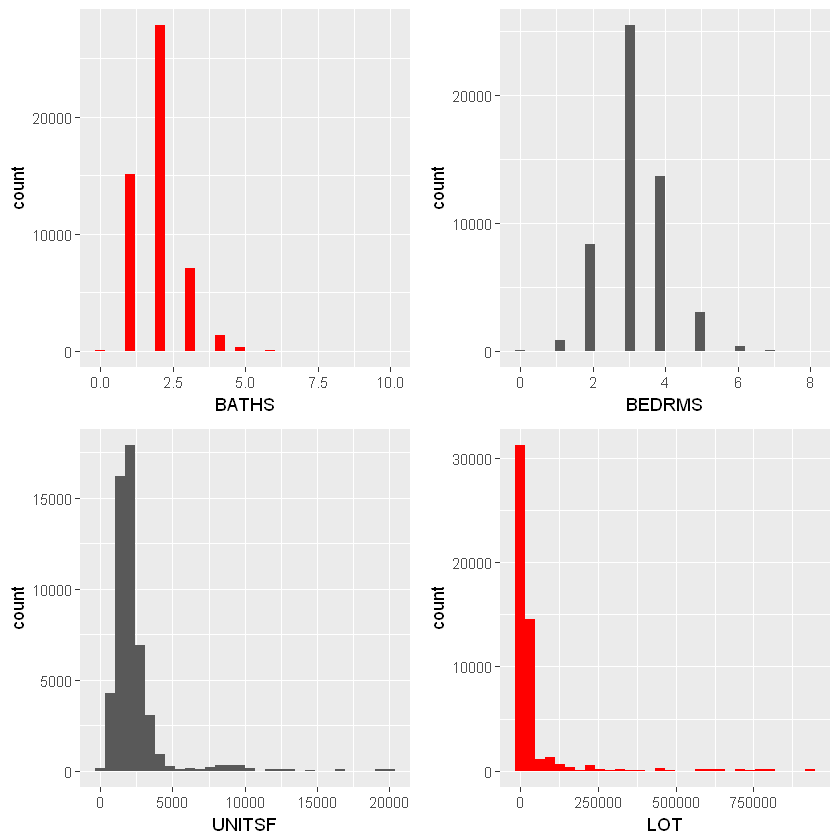

In [3]:
p1 = ggplot(Housing,aes(BATHS)) + geom_histogram(bins=30,fill='red')     
# full ggplot command
p2 = qplot(BEDRMS,data=Housing,bins=30)                                  
# qplot will do this automatically
p3 = qplot(UNITSF,data=Housing,bins=30)
p4 = ggplot(Housing,aes(LOT)) + geom_histogram(bins=30,fill='red')     

grid.arrange(p1,p2,p3,p4,ncol=2)

print('BED')
summary(Housing$BED)
print('BATHS')
summary(Housing$BATHS)
print('LOT')
summary(Housing$LOT)
print('UNITSF')
summary(Housing$UNITSF)

Given the distributions and positive values for UNITSF and LOT, it seems like a good idea to take logarithms of both of these variables.

Let's transform and re-examine the distribution.

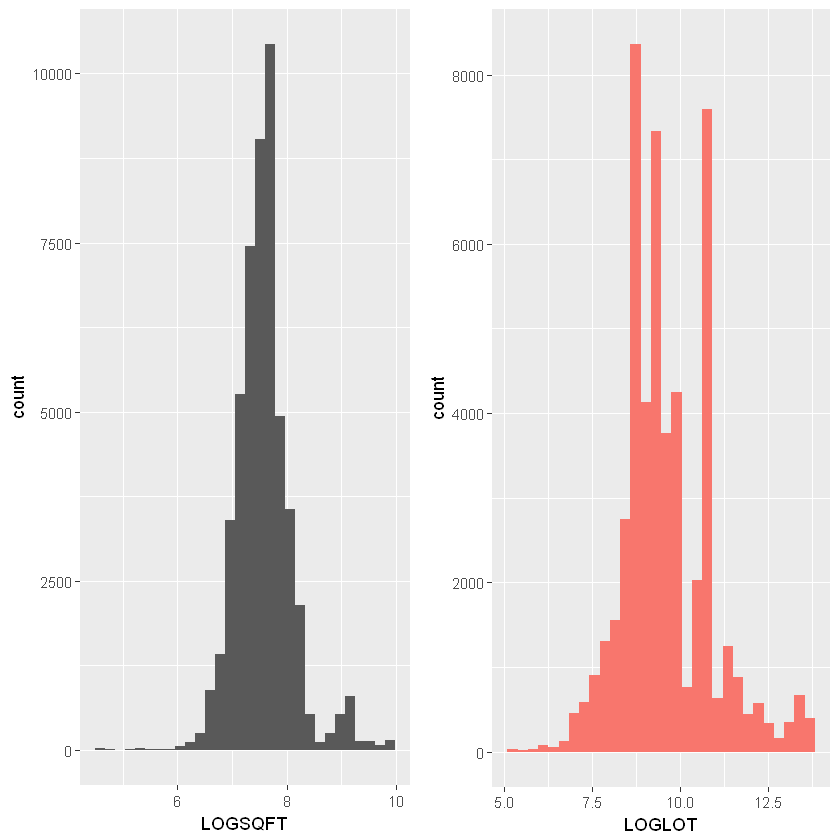

In [4]:

Housing$LOGSQFT = log(Housing$UNITSF)
Housing$LOGLOT = log(Housing$LOT)

p1 = qplot(LOGSQFT,data=Housing,bins=30)
p2 = qplot(LOGLOT,data=Housing,bins=30,fill='red') + guides(fill=FALSE)
grid.arrange(p1,p2,ncol=2)


Let's go ahead and look at the relationships between these variables and the housing price.

For ease of visualization let's randomly select 1000 observations to plot. 
We can utilize color to see 3d relationships on a 2d scatter plot.

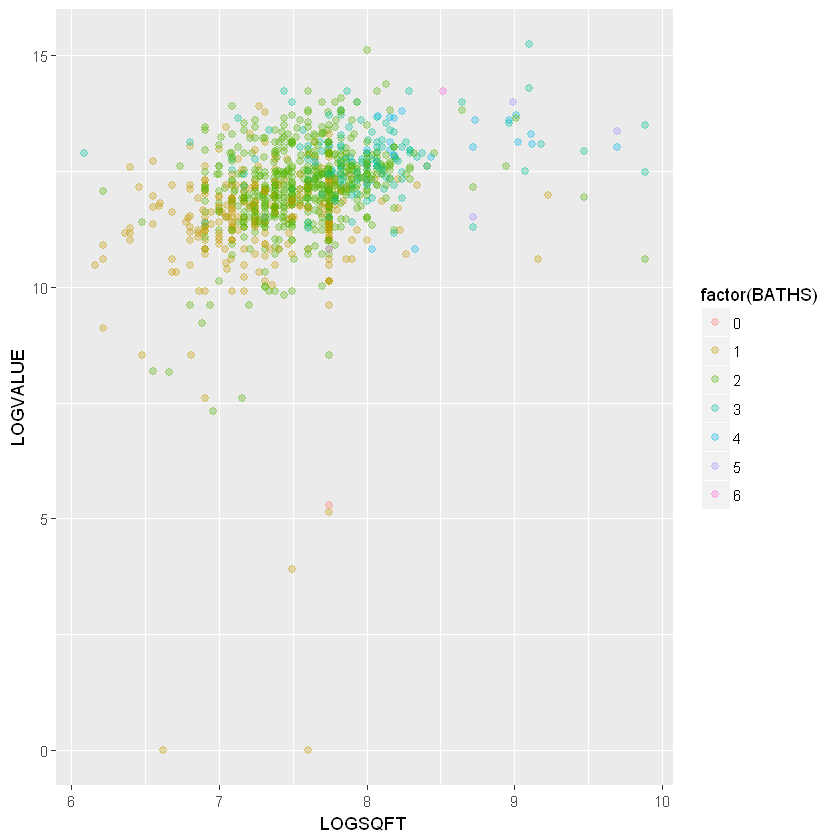

In [5]:
subset = Housing[sample(1:nrow(Housing),1000),]

ggplot(subset , aes(x = LOGSQFT, y = LOGVALUE)) +             
# Plotting relationship between Finished Area and log(price)
           geom_point(aes(color = factor(BATHS)),alpha=.3,size=2)       
# Color based on number of full bathrooms


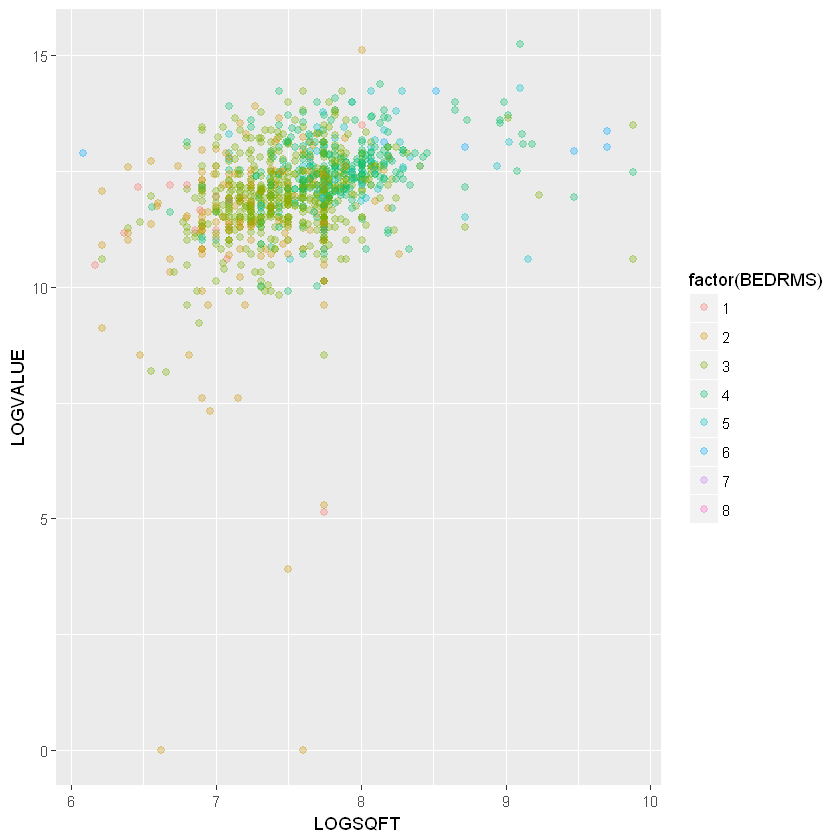

In [6]:
ggplot(subset , aes(x = LOGSQFT, y = LOGVALUE)) +        
# Plotting relationship between Finished Area and log(price)
           geom_point(aes(color = factor(BEDRMS)),alpha=.3,size=2)  
# Color based on number of bedrooms


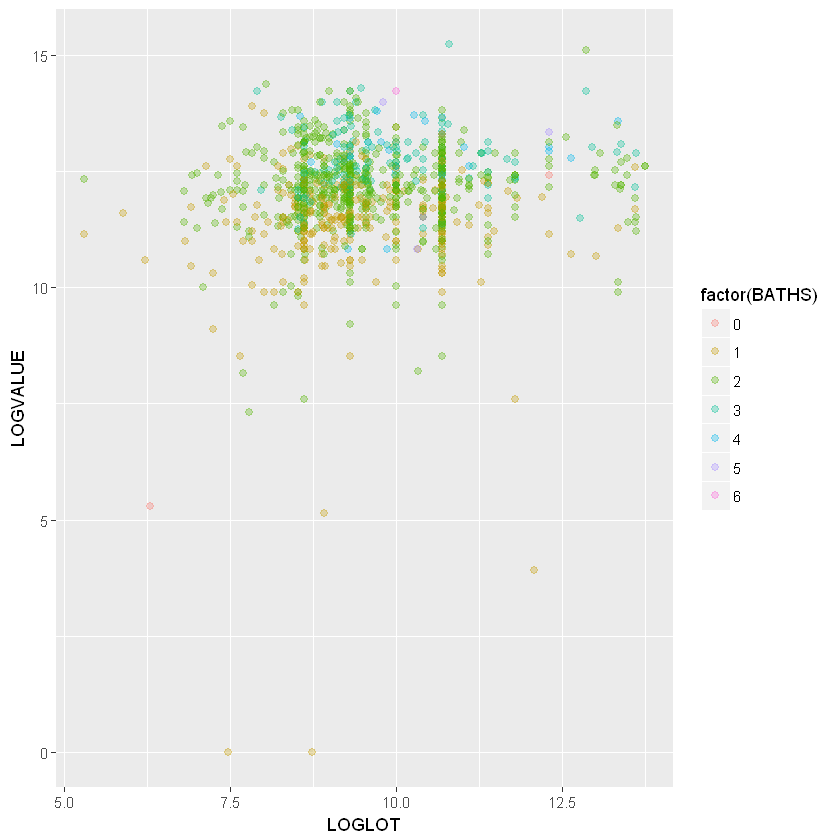

In [7]:
ggplot(subset , aes(x = LOGLOT, y = LOGVALUE)) +            
# Plotting relationshipo between Acreage and log(price)
           geom_point(aes(color = factor(BATHS)),alpha=.3,size=2)   
# Color based on number of full bathrooms


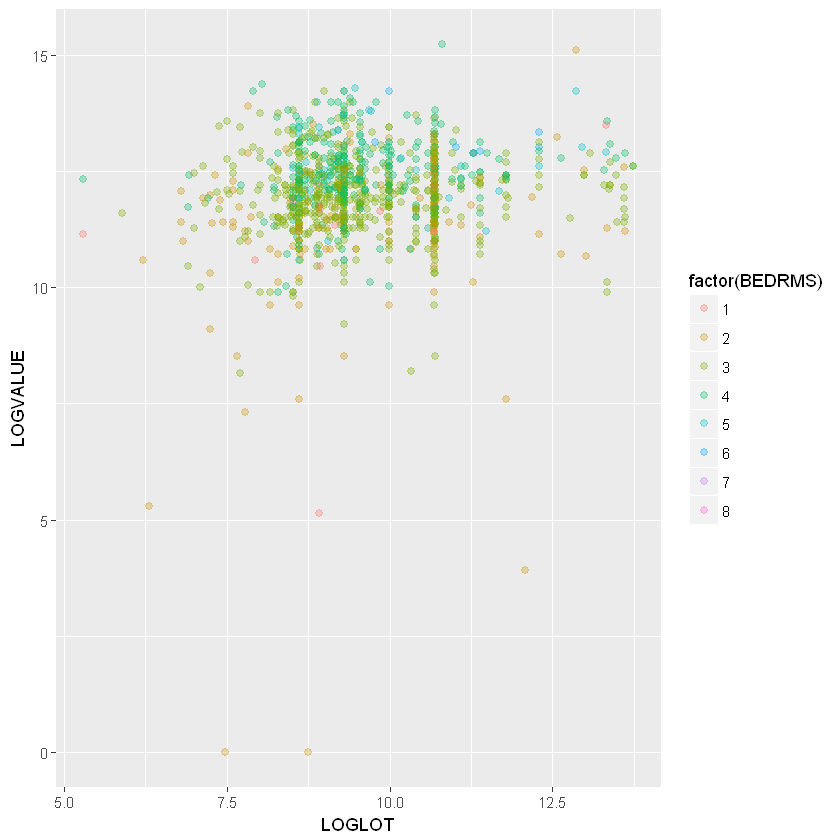

In [8]:
ggplot(subset , aes(x = LOGLOT, y = LOGVALUE)) +              
# Plotting relationshipo between Acreage and log(price)
           geom_point(aes(color = factor(BEDRMS)),alpha=.3,size=2)       
# Color based on number of bedrooms



So we observe what we expect, houses with larger finished areas have more bedrooms and bathrooms. The results are much less clear between acreage and bathrooms and bedrooms which is intuitive as well.

It looks like there is a positive correlation between each of these covariates with price, but lets start running some regressions.

First let's separate 10% of our sample as a validation set as before.

In [9]:
#Splitting the data

data_split = function(data,split=.1){

    N = dim(data)[1]                         
    random = sample(1:N,N,replace=F)         
    # Randomly choose the index for the splits
    data = data[random,]                      
    # Shuffle data
    test = data[1:round(N*split),]            
    # Splits
    train = data[(round(N*split)+1):N,]

    
    return(list(train,test))
}


tmp = data_split(Housing) 
train_test = tmp[[1]]
validation = tmp[[2]]


The first model we are running is $\log(value) = \beta_0 +\beta_1 \log(lot) + \beta_2 \log(sqft) + \beta_3 bedrooms + \beta_4 bathrooms + \varepsilon$

Instead of writing our own cross-validation function let's utilize the one built into the "caret" package.

The "train" function is a highly flexible way to estimate different models with various options. Here we are just running OLS so the method is "lm" (linear model). The cross-validation setting is inside the "trainControl" option. We specify "cv" for cross-validation and the number of folds to be 5.

In [10]:

train1 = train_test[c('LOGVALUE','LOGLOT','LOGSQFT','BEDRMS','BATHS')]

model <- train(
  LOGVALUE ~.,data = train1,               
    # formula for the model
  method = "lm",                           
    # OLS
  trControl = trainControl(
    method = "cv", number = 5,             
      # 5 fold cross-validatoin
  )
)

model

Linear Regression 

46627 samples
    4 predictor

No pre-processing
Resampling: Cross-Validated (5 fold) 
Summary of sample sizes: 37301, 37302, 37301, 37302, 37302 
Resampling results:

  RMSE      Rsquared   MAE      
  0.969964  0.1736206  0.6195024

Tuning parameter 'intercept' was held constant at a value of TRUE

The results aren't great here, but we also are only taking into account a few of the covariates.

Let's add in some of the location and house attributes.

We can directly add the variables by their names by adding the columns to the training data.

In [11]:
train2 = cbind(train1,train_test[c('REGION','METRO','KITCHEN','DISH',
                                   'WASH','DRY','COOK','DENS','DINING',
                                   'FAMRM','HALFB','LIVING','OTHFN',
                                   'RECRM','PORCH','SINK','LAUNDY',
                                   'FLOORS','CONDO','ROOMS','PLUMB',
                                   'NOWIRE','AGE')])
model <- train(
  LOGVALUE ~ .,data = train2 ,
  method = "lm",
  trControl = trainControl(
    method = "cv", number = 5,
  )
)


model

Linear Regression 

46627 samples
   27 predictor

No pre-processing
Resampling: Cross-Validated (5 fold) 
Summary of sample sizes: 37303, 37301, 37301, 37303, 37300 
Resampling results:

  RMSE       Rsquared   MAE     
  0.9032833  0.2836107  0.563848

Tuning parameter 'intercept' was held constant at a value of TRUE

The RMSE, MAE, and Rsquared improve a bit here. We still have a lot of covariates we can consider though.

Let's add a few more features to see if we can get better results.

Another way to select covariates in a data.frame is with "select". Here we are selecting all the covariates that have names beginning with "Roach","Rats","Water","Num", and "Freeze".

In [12]:
train3 = cbind(train2,select(train_test,starts_with('Roach')),
                   select(train_test,starts_with('Rats')),
              select(train_test,starts_with('Water')),
                   select(train_test,starts_with('Cellar')),
               select(train_test,starts_with('Num')),
                   select(train_test,starts_with('Freeze')))

model <- train(
  LOGVALUE ~ .,data = train3 ,
  method = "lm",
  trControl = trainControl(
    method = "cv", number = 5,
  )
)


model

Linear Regression 

46627 samples
   60 predictor

No pre-processing
Resampling: Cross-Validated (5 fold) 
Summary of sample sizes: 37301, 37301, 37304, 37300, 37302 
Resampling results:

  RMSE       Rsquared   MAE      
  0.8664426  0.3407582  0.5430362

Tuning parameter 'intercept' was held constant at a value of TRUE

This model has 60 predictors. This isn't huge on it's own, but you could imagine by adding interactions and power terms the number of predictors would increase very fast.

Once we have included all the covariates that we believe may be related to the model, we may want to apply a penalty term to improve out-of-sample performance. 

R makes this very easy for all generalized linear models with the glmnet package. 

Let's go ahead and run a lasso regression on the last model we looked at.

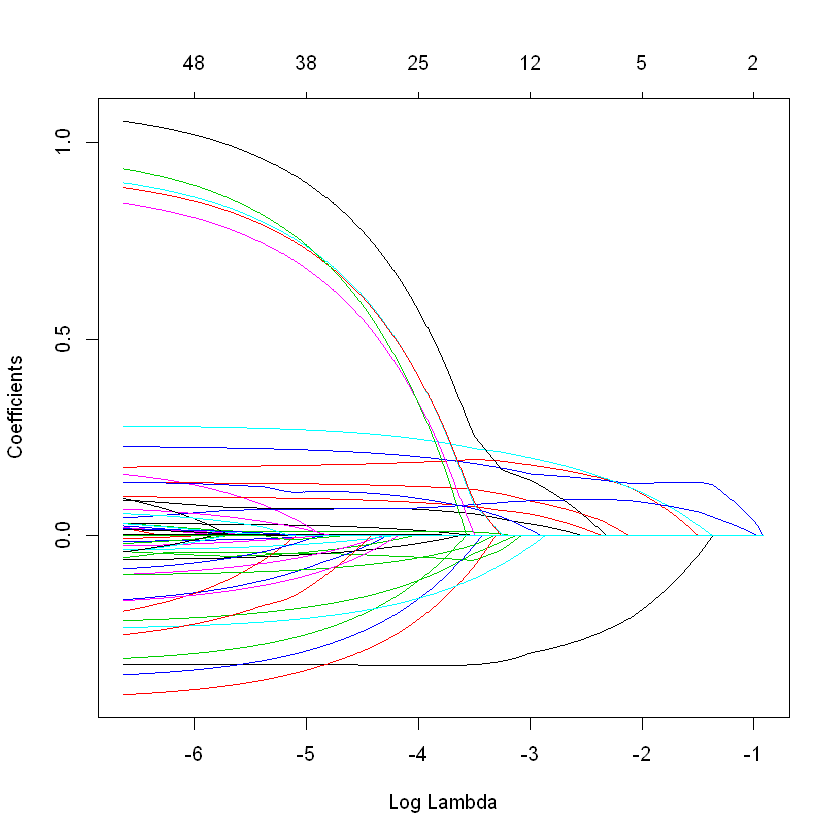

In [13]:
y = as.double(as.matrix(train3$LOGVALUE))                                     
# convert data.frame to matrix for use w/ glmnet
x = as.matrix(train3[,-1])

# alpha = 1 corresponds to Lasso

cv.lasso =cv.glmnet(x, y, family='gaussian', alpha=1, nfolds=5, nlambda=1000)             
# This will automatically cross-validate and                            
# optimize over a grid of penalty weights                            

# The plots are with respect to penalty weights

plot(cv.lasso$glmnet.fit, xvar="lambda")                                    
# The value of the estimated coefficients


We observe quite a few coefficients go to zero for small values of $\lambda$, but many of them are just shrinking slowly to $0$

We can also look at a ridge regression.

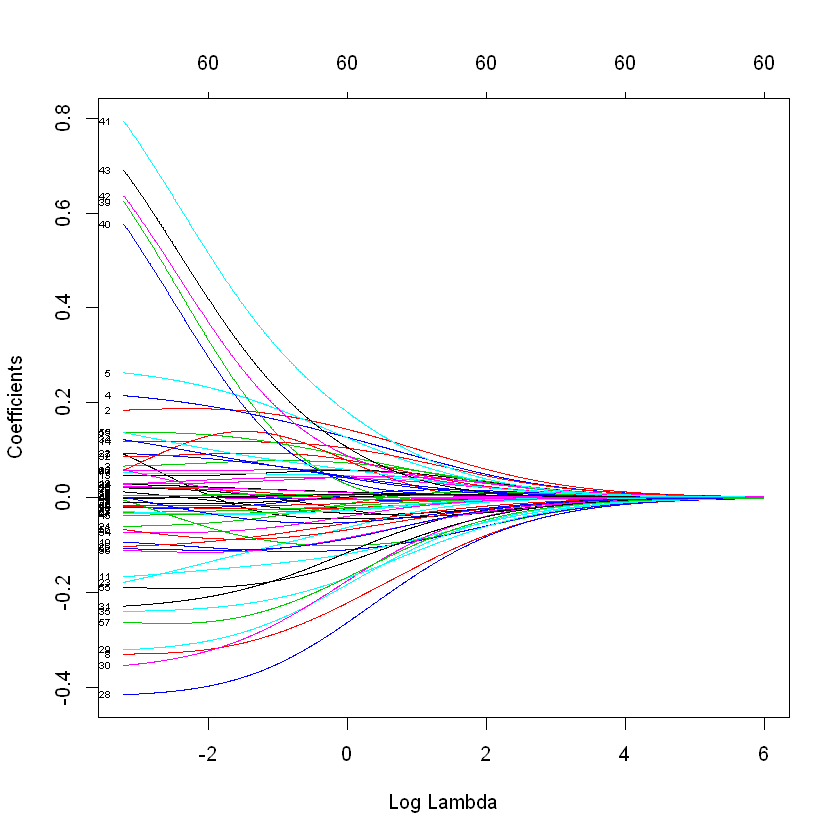

In [14]:
# alpha = 0 corresponds to Ridge

cv.ridge =cv.glmnet(x, y, family='gaussian', alpha=0, nfolds=5, nlambda = 1000)
plot(cv.ridge$glmnet.fit, xvar="lambda", label=TRUE)


The coefficient paths are distinctly different for the lasso and ridge regressions. The ridge penalty shrinks all the coefficients gradually to zero, while the lasso sets them to zero at different rates and is much sharper.

We can also consider an elastic-net type regression where we have both ridge and lasso penalties.

The $\alpha$ parameter determines the weight between the ridge and lasso penalties

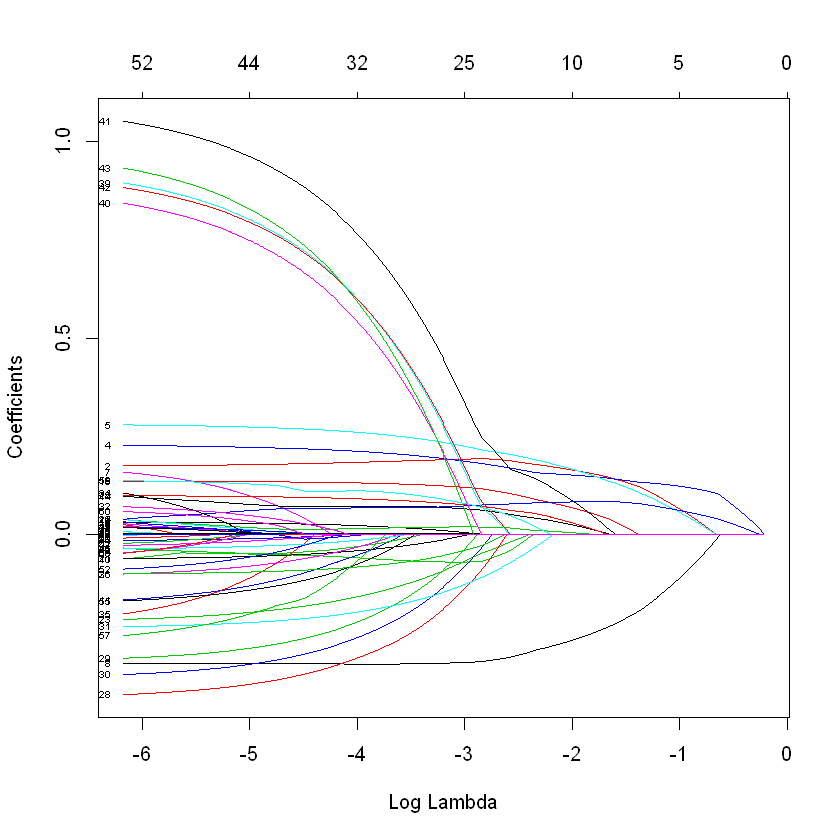

In [15]:
# alpha = .5 corresponds to a type of elastic-net, 
# the ridge and lasso penalty terms have equal weights

cv.enet =cv.glmnet(x, y, family='gaussian', alpha=.5, nlambda = 1000)

plot(cv.enet$glmnet.fit, xvar="lambda", label=TRUE)


The coefficient paths look exactly like a combination of the ridge and lasso shrinkage.

Comparing the results between OLS, Lasso, Ridge, and Elastic-Net ($\alpha=0.5$)

In [16]:
cat('OLS RMSE: ', model$results$RMSE)
cat('\nLasso RMSE: ', sqrt(min(cv.lasso$cvm)),
    ', corresponding to Lambda: ', cv.lasso$lambda.min)
cat('\nRidge RMSE: ' , sqrt(min(cv.ridge$cvm)),
    ', corresponding to Lambda: ', cv.ridge$lambda.min)
cat('\nENet RMSE: ' , sqrt(min(cv.ridge$cvm)),
    ', corresponding to Lambda: ', cv.enet$lambda.min)


OLS RMSE:  0.8664426
Lasso RMSE:  0.8664649 , corresponding to Lambda:  0.001339103
Ridge RMSE:  0.869627 , corresponding to Lambda:  0.04104881
ENet RMSE:  0.869627 , corresponding to Lambda:  0.002534079

OLS is holding its own with the competing models on this metric.

However, it is very possible that different combinations of alpha and lambda might produce better results. Let's go back to using the caret cross-validation package to tune $\alpha$ and $\lambda$ pairs.

We have already observed that the better performance is obtained for small values of lambda, lets vary alpha over this range.

In [17]:
model.shrinkage <- train(
  LOGVALUE ~ .,data = train3,
  method = "glmnet",                                                   
# method is no longer least squares
  tuneGrid = expand.grid(alpha = seq(0,1,.1),                        
# We are specifying the grid to be between [.1,.9]
                        lambda = seq(.001,.002,.0001)),
# "" [.001,.002] stepsizes are .1 and .0001 resp.
  trControl = trainControl(
    method = "cv", number = 10,
  )
)



In [18]:
print('OLS')
model$results[which.min(model$results$RMSE),]
print('Shrinkage')
model.shrinkage$results[which.min(model.shrinkage$results$RMSE),]


[1] "OLS"


intercept,RMSE,Rsquared,MAE,RMSESD,RsquaredSD,MAESD
TRUE,0.8664426,0.3407582,0.5430362,0.01269846,0.003812277,0.005118263


[1] "Shrinkage"


,alpha,lambda,RMSE,Rsquared,MAE,RMSESD,RsquaredSD,MAESD
46,0.4,0.0011,0.8655253,0.3420939,0.5426814,0.04127617,0.02555915,0.008424901


Let's see how it does on the validation data

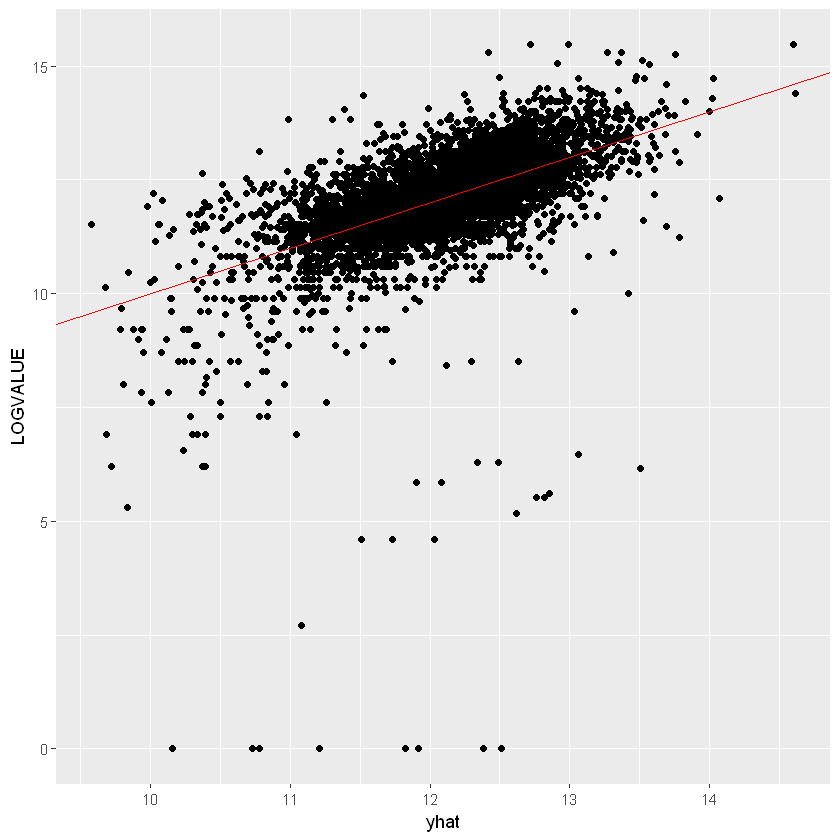

In [19]:
yhat = predict(model.shrinkage,newdata=validation)
out = cbind(yhat,validation)
ggplot(out, aes(yhat,LOGVALUE)) + geom_point() + geom_abline(slope=1,color='red')

Not too bad! A perfect prediction would have all the points falling on the red line, but we are capturing a lot of the variation in the data.

EXERCISE:

Take a random subsample of this data ($10\%$) and run Lasso, Ridge, and Elastic-Net ($\alpha=.5$). What shrinkage parameters  get selected? Which model does best in terms of out-of-sample performance?